### Building a basic chatbot with langgraph (graph API)

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph , START ,END
from langgraph.graph.message import add_messages  # this are called reducers(they append)

In [2]:
class State(TypedDict):
   #  Messagses have the type "list". The 'add_messages' function
   # in the annotation defines how this state key should be replaced
   # in this particular case it appends the messages instad of overwriting them
   messages:Annotated[list,add_messages] 

graph_builder = StateGraph(State)

In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
# Defining the LLMs
from langchain_groq import ChatGroq

from langchain.chat_models import init_chat_model

llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002AA98001FC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002AA9802C8E0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:

#node functionality
def chatbot(state:State):
    return{"messages":[llm.invoke(state["messages"])]}
    

In [8]:
graph_builder = StateGraph(State)


#adding node
graph_builder.add_node("My_Chatbot",chatbot)
#adding edges
graph_builder.add_edge(START,"My_Chatbot")
graph_builder.add_edge("My_Chatbot",END)


## compile the graph
graph = graph_builder.compile()

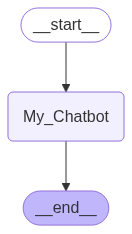

In [9]:
#visualize the graph

from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response = graph.invoke({"messages":"Hi"})

In [11]:
response["messages"]

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='652861e9-d8fb-430b-ba23-f020b8d2c2ee'),
 AIMessage(content='<think>\n\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 4, 'total_tokens': 20, 'completion_time': 0.06262842, 'prompt_time': 0.009431382, 'queue_time': 0.045458025, 'total_time': 0.072059802}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0f5dfac8-052c-4f49-a591-e6292b75e2b3-0', usage_metadata={'input_tokens': 4, 'output_tokens': 16, 'total_tokens': 20})]

In [12]:
#reading the perfect message

response["messages"][-1].content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

#displaying the information

#displaying

In [13]:
for event in graph.stream({"messages": "Hi how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)

<think>

</think>

Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊


# adding tools to this chatbot

In [14]:
from langchain_tavily import TavilySearch


tool = TavilySearch(max_results=2)
tool.invoke("What is LangChain?")
                    

{'query': 'What is LangChain?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.langchain.com/',
   'title': 'LangChain',
   'content': "Image 69 Image 70 Image 71 ###### ORCHESTRATION: ###### Build agents with LangGraph Image 72 Controllable agent orchestration with built-in persistence to handle conversational history, memory, and agent-to-agent collaboration. Image 77###### DEPLOYMENT: ###### Deploy &manage with LangGraph Platform Image 78 Deploy and scale enterprise-grade agents with long-running workflows. Image 79 Image 80 Image 81 Image 82 Image 83 Image 94 Image 95 Image 96 Image 97 Image 98 Image 99 Image 100 Image 101 Image 102 Image 103 Image 104 Image 105 Image 106 Trace using the TypeScript or Python SDK to gain visibility into your agent interactions -- whether you use LangChain's frameworks or not. Image 107 STACK 3:Any agent framework +LangGraph Platform Image 108 Image 112",
   'score': 0.98572,
   'raw_content': None},
 

In [15]:
## custom fucntion
def multiply(a:int,b:int) -> int:
    """
    Multiply a and b

    Args:
        a (int): First number
        b (int): Second number

    Returns:
        int: output int
    
    
    
    """


In [16]:
tools = [tool, multiply]

In [17]:


llm_with_tools =llm.bind_tools(tools)

In [19]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002AA98001FC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002AA9802C8E0>, model_name='deepseek-r1-distill-llama-70b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'descrip

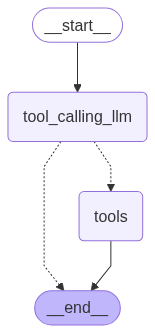

In [23]:
## stategraph with tools 
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode , tools_condition




def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools" , ToolNode(tools))


#add edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition  # this checks if the message contains a tool call

    # if the latest message contains a tool call, it will go to the tools node
    # otherwise it will go to the END node
)

builder.add_edge("tools", END)

##compile the graph
graph = builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
response = graph.invoke({"messages": "What is latest news about Tarrifs?"})

In [25]:
response["messages"][-1].content

'{"query": "latest news about tariffs", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://usw.ca/trumps-tariffs-resist-protect-our-jobs-rebuild-our-industries/", "title": "Trump\'s tariffs: Resist, protect our jobs, rebuild our industries", "content": "On March 12, Trump renewed tensions by imposing a 25% surtax on all U.S. steel and aluminum imports, with no exemptions for Canada. On April 3, 25% tariffs were", "score": 0.35602167, "raw_content": null}, {"url": "https://www.cnbc.com/2025/08/11/trump-china-tariffs-deadline-extended.html", "title": "Trump extends China tariff deadline by 90 days - CNBC", "content": "President Donald Trump has signed an executive order that will prevent U.S. tariffs on Chinese goods from spiking for another 90 days.", "score": 0.27851966, "raw_content": null}], "response_time": 1.25}'

In [26]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is latest news about Tarrifs?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (jr4qtr7qc)
 Call ID: jr4qtr7qc
  Args:
    exclude_domains: ['blogspot.com', 'medium.com']
    query: latest news about tariffs
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news about tariffs", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://usw.ca/trumps-tariffs-resist-protect-our-jobs-rebuild-our-industries/", "title": "Trump's tariffs: Resist, protect our jobs, rebuild our industries", "content": "On March 12, Trump renewed tensions by imposing a 25% surtax on all U.S. steel and aluminum imports, with no exemptions for Canada. On April 3, 25% tariffs were", "score": 0.35602167, "raw_content": null}, {"url": "https://www.cnbc.c